<a href="https://colab.research.google.com/github/mintusf/CIFAR/blob/master/Dataset_preparation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script's objective is to prepare the dataset for a task. Procedures includes:


*   Downloading data
*   Deleting images to be undersampled (50% of classes [bird, deer, truck])
*   Preparing augmented dataset to balance the distribution of classes
*   Save all 4 datasets: training dataset with undersampled data, training dataset with augmented data, development and test datasets with balanced classes distribution

First, let's download CIFAR-10 dataset and check shapes.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
(X_train_original, Y_train_original_1d), (X_test,Y_test_1d) = cifar10.load_data()
X_train_original = X_train_original/255.

print(X_train_original.shape)
print(X_test.shape)
print(Y_train_original_1d.shape)
print(Y_test_1d.shape)

170500096/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


## Dataset preparation

The assumption of the problem is that classes [bird, deer, truck] should be limited to 50%. Following function is deleting images from dataset.



> Arguments:


*   X -> numpy array containing examples from dataset
*   Y -> numpy array labels corresponding labels
*   ratio -> float indicating how big part of class should be deleted
*   class_no -> integer indicating which class should be undersampled




> Returns:


*   X -> numpy array containing new dataset with chosen classes undersampled
*   Y -> numpy array containing corresponding labels
*   deleted_examples -> numpy array containing deleted examples
*   deleted_labels -> numpy array containing corresponding labels








In [0]:
def del_img (X, Y, ratio, class_no):
  
  m = X.shape [0]
  class_count = 0

  # creating empty arrays for deleted dataset
  deleted = []
  deleted_labels = []

  # counting number of examples of selected class
  class_count = np.sum(Y==class_no)

  # for repeatable results
  np.random.seed(1)

  # creating and shuffling array of indices
  a = np.arange(class_count)
  np.random.seed(1)
  np.random.shuffle(a)

  # picking indices of examples to be deleted
  img_to_del = a [:int(class_count*ratio)]
  img_to_del_wholearray = []
  counter = 0

  # looping through the array to find global indices instances of chosen class to be deleted and saving these instances 
  for i in range(m):
      if Y[i]==class_no:
          if counter in img_to_del:
              img_to_del_wholearray.append(i)
              deleted.append (X[i])
              deleted_labels.append(int(Y[i]))
          counter += 1
  
  # deleting examples and labels at randomly chosen indices of selected class
  X = np.delete(X,img_to_del_wholearray,axis = 0)
  Y = np.delete(Y,img_to_del_wholearray,axis = 0)
  deleted_examples = np.array(deleted,dtype=np.uint8)
  return X, Y, deleted_examples, deleted_labels

In [3]:
deleted_all = np.empty((0,32,32,3),dtype=np.uint8)
deleted_labels_all = np.empty((0),dtype = np.int8)


# Deleting half of birds, deer and deerrs
  
#deleting half of birds images
X_train, Y_train_1d, deleted,deleted_labels = del_img(X_train_original, Y_train_original_1d, 0.5,2)
deleted_all = np.append(deleted_all,deleted,axis = 0)
deleted_labels_all = np.append(deleted_labels_all,deleted_labels,axis = 0)
  
#deleting half of deer images
X_train, Y_train_1d, deleted,deleted_labels = del_img(X_train, Y_train_1d, 0.5,4)
deleted_all = np.append(deleted_all,deleted,axis = 0)
deleted_labels_all = np.append(deleted_labels_all,deleted_labels,axis = 0)
  
#deleting half of truck images
X_train, Y_train_1d, deleted,deleted_labels = del_img(X_train, Y_train_1d, 0.5,9)
deleted_all = np.append(deleted_all,deleted,axis = 0)
deleted_labels_all = np.append(deleted_labels_all,deleted_labels,axis = 0)

print(X_train.shape)
print(deleted_all.shape)
print(deleted_labels_all.shape)

(42500, 32, 32, 3)
(7500, 32, 32, 3)
(7500,)


Next cell defines two function for validation of created dataset. Function "Count_class" counts instances of a class in dataset and function "show_img" show randomly chosen examples with labels.

In [0]:
# list with class names
names = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

def count_class (Y,class_no):
  class_count = 0
  for i in range (Y.shape[0]):
      if Y[i]==class_no:
          class_count += 1
  return class_count


import matplotlib.pyplot as plt
def show_img (X,Y,no):
  idx = np.random.randint(Y.shape [0],size = no)  
  for i in idx:
      #step1 = X[i,:,:,:]
      plt.imshow(X[i])
      plt.show()
      print(names[int(Y[i])])

Let's check number of examples of each class in labels vector as well as random images if dataset and labels are synchronized.

Examples of class airplane: 5000
Examples of class automobile: 5000
Examples of class bird: 2500
Examples of class cat: 5000
Examples of class deer: 2500
Examples of class dog: 5000
Examples of class frog: 5000
Examples of class horse: 5000
Examples of class ship: 5000
Examples of class truck: 2500


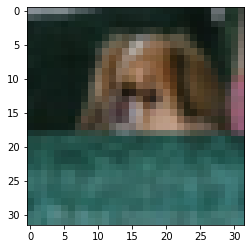

dog


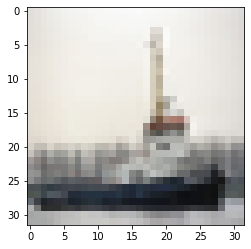

ship


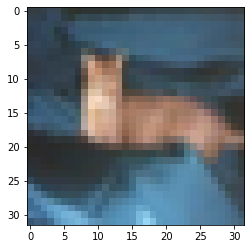

cat


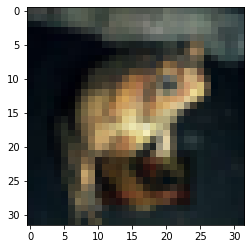

frog


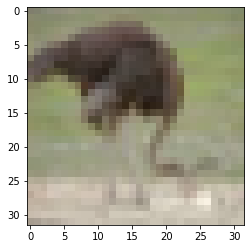

bird


In [5]:
for i in range(10):  
    print(f'Examples of class {names[i]}: ' + str(count_class(Y_train_1d,i)))

show_img(X_train,Y_train_1d,5)


It proves that the dataset was divided properly.

# Data augmentation



Since dataset is unbalanced in terms of class distribution, it can cause unbalanced training which could lead to 'naive' network where one class has higher probability to be predicted. In the case of CIFAR-10, the model should not have any 'preferable' class therefore some countermeasures should be implemented. According to publication https://arxiv.org/pdf/1710.05381.pdf, a good way to deal with unbalanced dataset is minority oversampling. In order to decrease possibility of overfitting, this method will be combined with data augmentation. In this section, new 2500 examples of undersampled classes will be created.

Next function adds augmented examples to a dataset.


> Arguments:


*   X -> numpy array containing examples from dataset
*   Y -> numpy array labels corresponding labels
*   class_no -> integer indicating which class should be undersampled
*   amount -> number of new images to be created



> Returns:



*   X -> dataset with augmented examples appended
*   Y -> corresponding labels






In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def add_augmented(X,Y,class_no,amount):

  # definition of data generator using keras function
  datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=False,
    fill_mode='nearest')
  i = 1

  # separate only images of selected class for generator
  X_separated = X[Y==class_no] 
  m = X_separated.shape[0]
  for batch in datagen.flow(X_separated, batch_size=1): # getting iterator
      generated = batch.astype(np.uint8)
      X = np.append(X, generated,axis=0)
      i += 1

      # Since generator is generating images continously, loop break is needed
      if i > amount:
          break
  Y = np.append(Y,(class_no*np.ones((amount,1))).astype(np.uint8))
  return X, Y

In order to add 2500 examples for each of undersampled class [bird, deer, truck], function will be run 3 times. Cell might take 10 minutes to run.

In [7]:
with tf.device('/device:GPU:0'):
  X_train_aug, Y_train_1d_aug = add_augmented(X_train,Y_train_1d.flatten(),2,2500)
  print('Birds addded')
  X_train_aug, Y_train_1d_aug = add_augmented(X_train_aug,Y_train_1d_aug.flatten(),4,2500)
  print('Deers added')
  X_train_aug, Y_train_1d_aug = add_augmented(X_train_aug,Y_train_1d_aug.flatten(),9,2500)
  print('Trucks added')

Birds addded
Deers added
Trucks added


Let's shuffle obtained dataset.

In [0]:
np.random.seed(1)
permutation = list(np.random.permutation(X_train_aug.shape[0]))
X_train_aug = X_train_aug[permutation, :, :, :]
Y_train_1d_aug = Y_train_1d_aug[permutation]

And finally, let's divide test dataset into development dataset, which would be used in the network development process and test dataset, which would be used to judge the network on data that is has never seen.

In [0]:
from sklearn.model_selection import train_test_split
X_test,X_dev, Y_test_1d, Y_dev_1d = train_test_split(X_test,Y_test_1d,test_size = 0.5)

In the last step, let's evaluate created dataset before using them for classification problem solving.

In [10]:
for i in range (10):
  print(f'Class: {names[i]}')
  print('Training dataset: \t\t' + str(count_class(Y_train_1d,i)))
  print('Training dataset (augmented): \t' + str(count_class(Y_train_1d_aug,i)))
  print('Test dataset: \t\t\t' + str(count_class(Y_test_1d,i)))
  print('Development dataset: \t\t' + str(count_class(Y_dev_1d,i)))
  print('\n')

Class: airplane
Training dataset: 		5000
Training dataset (augmented): 	5000
Test dataset: 			494
Development dataset: 		506


Class: automobile
Training dataset: 		5000
Training dataset (augmented): 	5000
Test dataset: 			478
Development dataset: 		522


Class: bird
Training dataset: 		2500
Training dataset (augmented): 	5000
Test dataset: 			495
Development dataset: 		505


Class: cat
Training dataset: 		5000
Training dataset (augmented): 	5000
Test dataset: 			513
Development dataset: 		487


Class: deer
Training dataset: 		2500
Training dataset (augmented): 	5000
Test dataset: 			488
Development dataset: 		512


Class: dog
Training dataset: 		5000
Training dataset (augmented): 	5000
Test dataset: 			525
Development dataset: 		475


Class: frog
Training dataset: 		5000
Training dataset (augmented): 	5000
Test dataset: 			488
Development dataset: 		512


Class: horse
Training dataset: 		5000
Training dataset (augmented): 	5000
Test dataset: 			486
Development dataset: 		514


Class: 

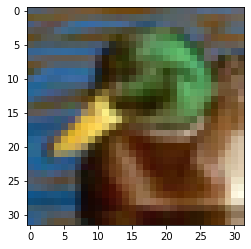

bird


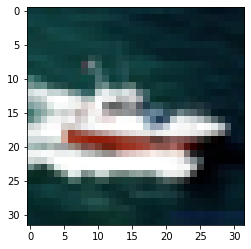

ship


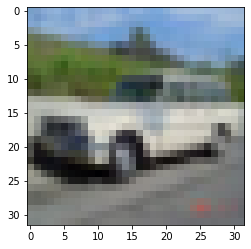

automobile


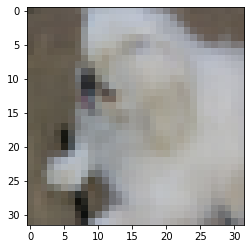

dog


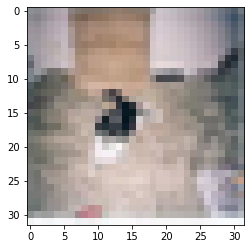

cat


In [26]:
show_img(X_train_aug,Y_train_1d_aug,5)